# Fundamentos de analítica 2 (clase 3)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com

## **1. Carga de paquetes**

In [1]:
#!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## **2. Carga de datos**



In [2]:
data = pd.read_excel(r'https://github.com/alfa7g7/Fundamentos-analitica-II/raw/main/Clase%201/Ejercicio%20en%20clase.-20240802/datosEmpleo.xlsx', index_col='mes', parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(220, 4)


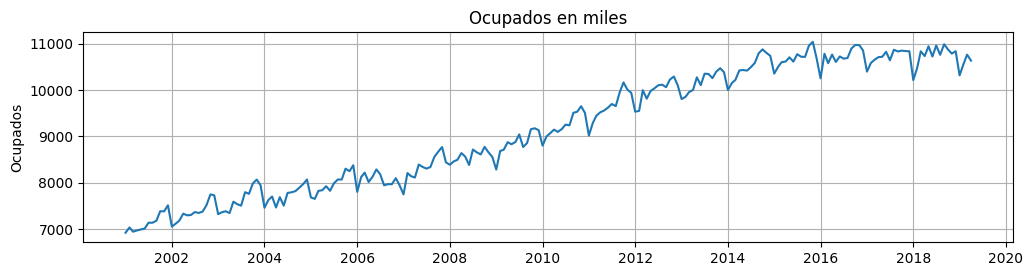

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Ocupados en miles")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

Protocolos de evaluación:

In [4]:
# Separar los datos en entrenamiento y prueba
horizon = 6 # El numero de pronósitco que queremos hacer hacia el futuro
train_len = len(data)- horizon
data_train = data.iloc[:train_len]
data_test = data.iloc[train_len:]

In [5]:
data_train

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911
...,...,...,...,...
2018-06-01,11.071347,10720.946,1334.725,6101.948
2018-07-01,10.125100,10959.197,1234.638,5984.340
2018-08-01,10.085244,10756.782,1206.529,6235.352


In [6]:
data_test

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2018-11-01,9.844539,10783.299,1177.484,6298.992
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575


## **3. ACF y PACF**

In [7]:
acf(data_train['Ocupados'],80) # es el numero de resagos

array([ 1.        ,  0.97791615,  0.96080801,  0.94667826,  0.93331952,
        0.92246288,  0.90890425,  0.89895712,  0.88616889,  0.87708222,
        0.87157593,  0.86626345,  0.86077083,  0.84142836,  0.82399124,
        0.8082148 ,  0.79697724,  0.78604389,  0.77291991,  0.76236066,
        0.74958796,  0.73837173,  0.73113649,  0.72434815,  0.7167177 ,
        0.69754163,  0.67796414,  0.66216212,  0.64826997,  0.63651197,
        0.62190178,  0.60943523,  0.59693407,  0.58423665,  0.57711519,
        0.57028981,  0.5606386 ,  0.53938066,  0.52087047,  0.50524286,
        0.49022537,  0.47732197,  0.46116269,  0.44869072,  0.4338035 ,
        0.42032113,  0.41028   ,  0.40035637,  0.38982644,  0.36876455,
        0.34815665,  0.331989  ,  0.31818874,  0.3052246 ,  0.28935639,
        0.27664314,  0.26282466,  0.25123173,  0.24267572,  0.23345379,
        0.22375204,  0.20333509,  0.18758961,  0.17295868,  0.15982591,
        0.14786426,  0.13436311,  0.12309555,  0.10875995,  0.09

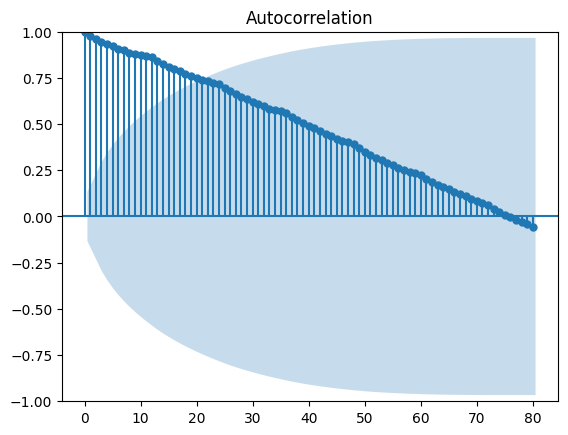

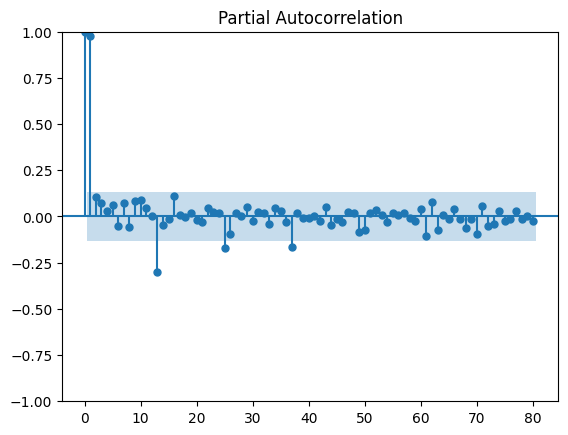

In [8]:
plot_acf(data_train['Ocupados'],lags=80);
plot_pacf(data_train['Ocupados'],lags=80);

<Figure size 1200x600 with 0 Axes>

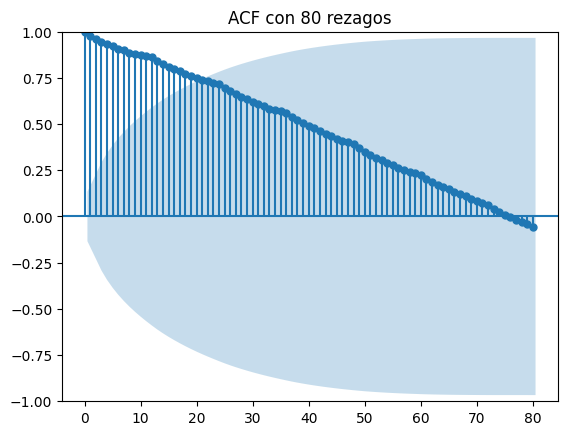

<Figure size 1200x600 with 0 Axes>

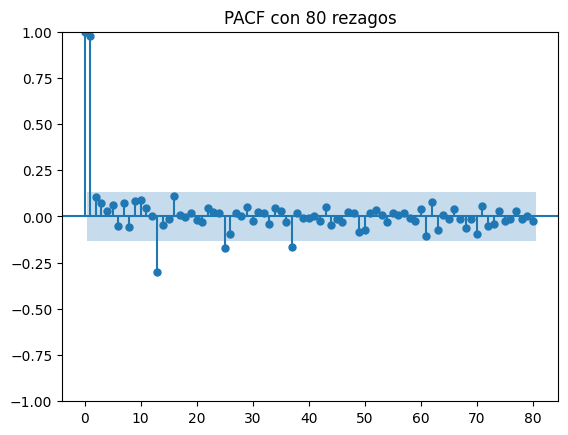

In [9]:
# Calcular y graficar ACF
plt.figure(figsize=(12, 6))
plot_acf(data_train['Ocupados'], lags=80)
plt.title('ACF con 80 rezagos')
plt.show()

# Calcular y graficar PACF
plt.figure(figsize=(12, 6))
plot_pacf(data_train['Ocupados'], lags=80)
plt.title('PACF con 80 rezagos')
plt.show()


Buscando el mejor modelo ARIMA:

In [14]:
# Lista de criterios de información a probar
criterios = ['aic', 'aicc', 'bic', 'hqic', 'oob']

# Diccionario para almacenar los resultados
modelos = {}
resultados = []

for criterio in criterios:
    try:
        # Entrenar el modelo Auto ARIMA con el criterio actual
        model = auto_arima(data_train["Ocupados"], 
                           max_p=10, 
                           max_q=10, 
                           information_criterion=criterio) 
                           
        
        # Obtener el valor del criterio para el modelo entrenado
        if criterio == 'aic':
            valor_criterio = model.aic()
        elif criterio == 'bic':
            valor_criterio = model.bic()
        elif criterio == 'hqic':
            valor_criterio = model.hqic()
        elif criterio == 'aicc':
            n = len(data_train)
            k = model.get_params()['order'][0] + model.get_params()['order'][1] + model.get_params()['order'][2] + model.get_params()['seasonal_order'][0] + model.get_params()['seasonal_order'][1] + model.get_params()['seasonal_order'][2] # Sumar el número de parámetros
            #k = model.n_params()
            aic = model.aic()
            valor_criterio = aic + (2 * k * (k + 1)) / (n - k - 2)
        elif criterio == 'oob':
            # Notar que 'oob' no está disponible para modelos ARIMA en pmdarima, asignamos un valor alto
            valor_criterio = float('inf')
        else:
            valor_criterio = float('inf')  # Asignar un valor alto si el criterio no se puede calcular
        
        # Almacenar el modelo y su valor de criterio
        modelos[criterio] = {
            'modelo': model,
            'valor_criterio': valor_criterio
        }
        
        # Agregar resultados al DataFrame
        resultados.append({
            'Criterio': criterio.upper(),
            'Valor_Criterio': valor_criterio,
            'Resumen_Modelo': model.summary()
        })

        # Mostrar el resumen del modelo para cada criterio
        #print(f"Modelo con criterio {criterio.upper()}:")
        #print(model.summary())
        #print("\n" + "="*80 + "\n")
        
    except Exception as e:
        print(f"Error con el criterio {criterio.upper()}: {e}")

# Crear un DataFrame con todos los resultados de los modelos
resultados_df = pd.DataFrame(resultados)

# Mostrar el DataFrame con los resultados
print("\n Estos fueron los diferentes criterios de los modelos auto arima: \n")
print(resultados_df)

C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\pmdarima\arima\_validation.py:35: UserWarning: information_criterion cannot be 'oob' with out_of_sample_size = 0. Falling back to information criterion = aic.
  warnings.warn('information_criterion cannot be \'oob\' with '



 Estos fueron los diferentes criterios de los modelos auto arima: 

  Criterio  Valor_Criterio                                     Resumen_Modelo
0      AIC     2800.549087                                 SARIMAX Results...
1     AICC     2800.663920                                 SARIMAX Results...
2      BIC     2813.994256                                 SARIMAX Results...
3     HQIC     2805.982727                                 SARIMAX Results...
4      OOB             inf                                 SARIMAX Results...


In [15]:
# Encontrar el mejor modelo basado en el valor más bajo del criterio
mejor_criterio = min(modelos, key=lambda k: modelos[k]['valor_criterio'])
mejor_modelo = modelos[mejor_criterio]['modelo']

print(f"\nEl mejor modelo fue seleccionado usando el criterio {mejor_criterio.upper()}.")
print("\nResumen del mejor modelo:\n")
print(mejor_modelo.summary())


El mejor modelo fue seleccionado usando el criterio AIC.

Resumen del mejor modelo:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Fri, 23 Aug 2024   AIC                           2800.549
Time:                        15:18:13   BIC                           2813.994
Sample:                    01-01-2001   HQIC                          2805.983
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3401      2.394      4.320      0.000       5.648      15.032
ar.L1          0.4455      0.096      4.657  

In [16]:
mejor_modelo.resid()

mes
2001-01-01    6904.955213
2001-02-01     157.874091
2001-03-01     -40.468263
2001-04-01      26.666541
2001-05-01      20.251385
                 ...     
2018-06-01    -197.962151
2018-07-01     153.306792
2018-08-01    -185.101577
2018-09-01     146.436429
2018-10-01     -94.770743
Length: 214, dtype: float64

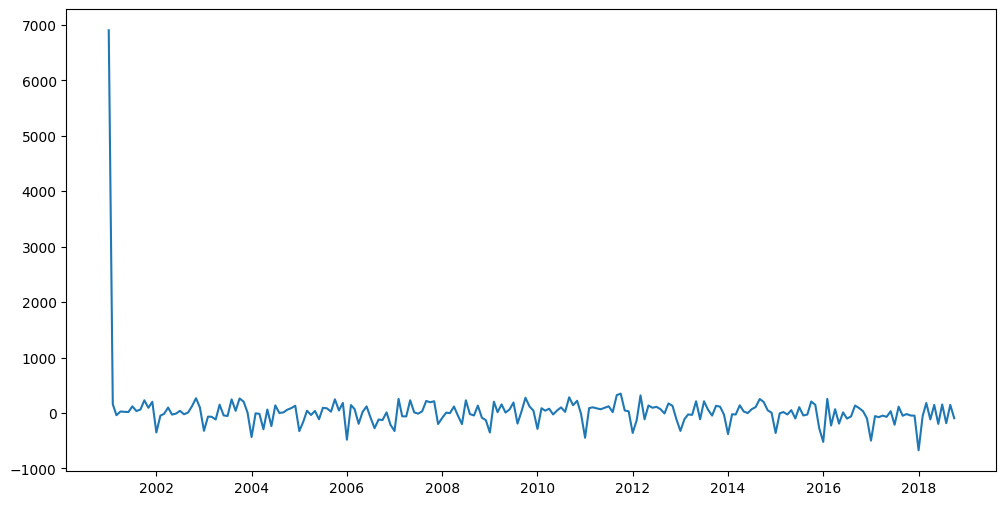

In [17]:
fig = plt.figure(figsize=(12, 6))
plt.plot(mejor_modelo.resid(),label="Residuales")

ARIMA con "aic"

In [10]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(data_train["Ocupados"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Fri, 23 Aug 2024   AIC                           2800.549
Time:                        15:18:01   BIC                           2813.994
Sample:                    01-01-2001   HQIC                          2805.983
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3401      2.394      4.320      0.000       5.648      15.032
ar.L1          0.4455      0.096      4.657      0.000       0.258       0.633
ma.L1         -0.8728      0.048    -18.169      0.000      -0.967      -0.779
sigma2      2.871e+04   2475.423     11.598      0.000    2.39e+04    3.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                48.07
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.93
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
model.resid()

mes
2001-01-01    6904.955213
2001-02-01     157.874091
2001-03-01     -40.468263
2001-04-01      26.666541
2001-05-01      20.251385
                 ...     
2018-06-01    -197.962151
2018-07-01     153.306792
2018-08-01    -185.101577
2018-09-01     146.436429
2018-10-01     -94.770743
Length: 214, dtype: float64

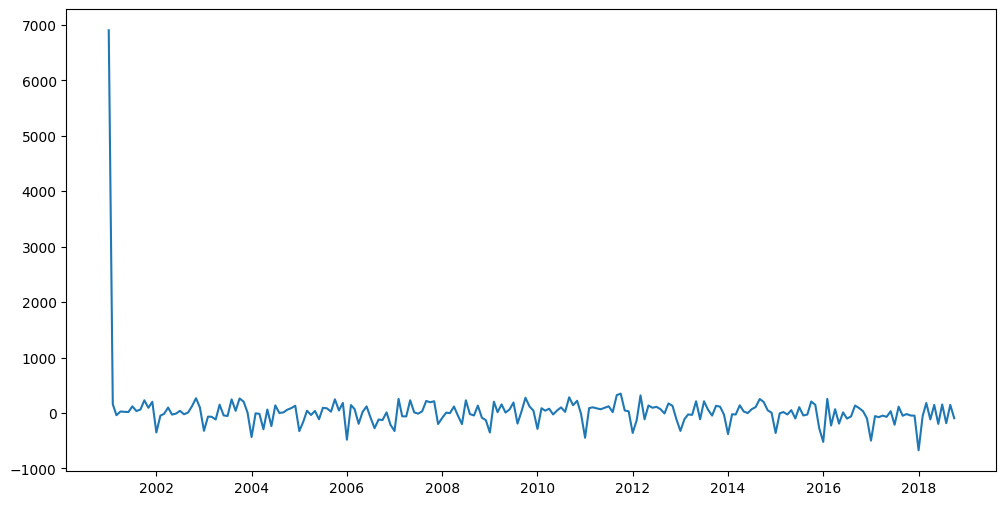

In [12]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid(),label="Residuales")

## **4. Pronóstico del ARIMA(1,1,1) obtenido en el auto.arima**


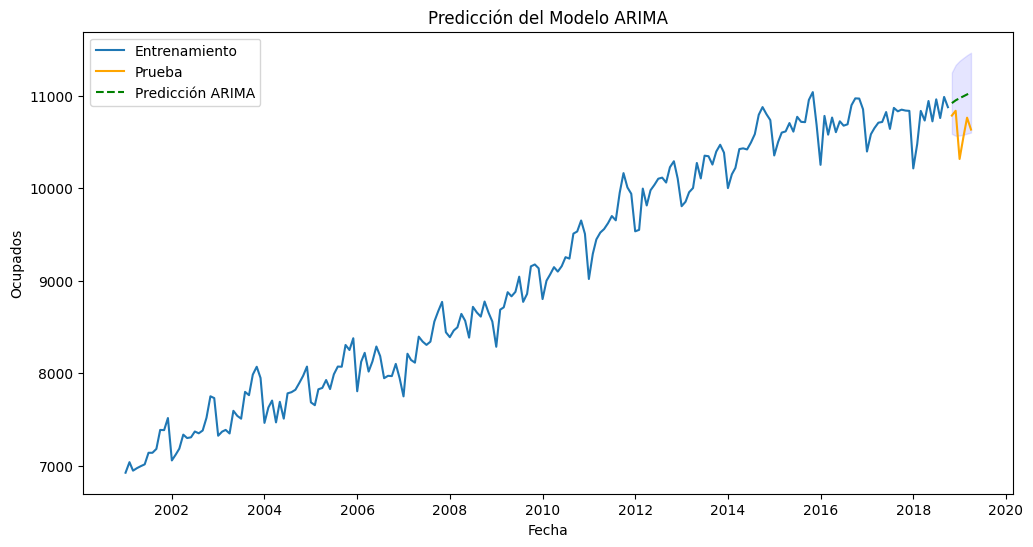

In [18]:
# Número de pasos a futuro para la predicción
h = 6  # Usamos 6 ya que es el tamaño de 'data_test'

# Realizar predicciones con el mejor modelo
y_forec, conf_int = mejor_modelo.predict(n_periods=h, return_conf_int=True, alpha=0.05)

# Crear un DataFrame con las predicciones y los intervalos de confianza
preds = pd.DataFrame(np.column_stack([y_forec, conf_int[:,0], conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.index = data_test.index

# Crear un rango para el eje x de la predicción
x_for = np.arange(len(data_train), len(data_train) + h)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train["Ocupados"], label="Entrenamiento")
plt.plot(data_test.index, data_test["Ocupados"], label="Prueba", color='orange')
plt.plot(preds.index, preds['Point_forecast'], label="Predicción ARIMA", color='green', linestyle='--')
plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title('Predicción del Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ocupados')
plt.show()


## **5. Replicando el modelo sin hacer auto arima**

In [19]:
model = ARIMA(order=(1,1,1))
results = model.fit( data_train["Ocupados"])
results.summary()

C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1396.275
Date:                Fri, 23 Aug 2024   AIC                           2800.549
Time:                        15:18:14   BIC                           2813.994
Sample:                    01-01-2001   HQIC                          2805.983
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3401      2.394      4.320      0.000       5.648      15.032
ar.L1          0.4455      0.096      4.657      0.000       0.258       0.633
ma.L1         -0.8728      0.048    -18.169      0.000      -0.967      -0.779
sigma2      2.871e+04   2475.423     11.598      0.000    2.39e+04    3.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                48.07
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.93
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ya hicimos comparaciones usando este método manual y el mejor modelo obtenido en el bucle obteniendo los mismos resultados por ende dejamos en uso la codificación donde se enuncia mejor modelo 

## **6. Intervalos de confianza usando boostrap**


In [20]:
# Número de pasos a futuro para la predicción
h= 6

# Obtener residuos del mejor modelo ajustado en `data_train`
#res = results.resid()
res = mejor_modelo.resid()

# Generar muestras de residuos
my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

# Calcular cuantiles para los intervalos de confianza
q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0) 

# Realizar predicciones con el mejor modelo
#fore = results.predict(h,return_conf_int=False)
fore = mejor_modelo.predict(n_periods=h, return_conf_int=False)

# Crear DataFrame con las predicciones y los intervalos de confianza
preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.index = data_test.index  # Asegurarse de que el índice sea el del conjunto de datos de prueba
preds


,Point_forecast,lower_95,upper_95
mes,,,
2018-11-01,10918.120132,10484.098038,11235.153794
2018-12-01,10947.966699,10132.428308,11539.848097
2019-01-01,10971.604487,9722.044002,11838.333621
2019-02-01,10992.476047,9381.229578,12124.956945
2019-03-01,11012.115157,9018.039745,12427.464452
2019-04-01,11031.205167,8654.300813,12712.306226


In [40]:
preds.Point_forecast

mes
2018-11-01    10918.120132
2018-12-01    10947.966699
2019-01-01    10971.604487
2019-02-01    10992.476047
2019-03-01    11012.115157
2019-04-01    11031.205167
Name: Point_forecast, dtype: float64

Calculamos el RMSE del modelo

In [41]:
# Calculamos el RMSE teniendo predicciones preds.Point_forecast vs valores reales data_test['Ocupados']
rmse = np.sqrt(mean_squared_error(data_test['Ocupados'], preds.Point_forecast))
print(f"RMSE: {rmse}")



RMSE: 381.678658001829


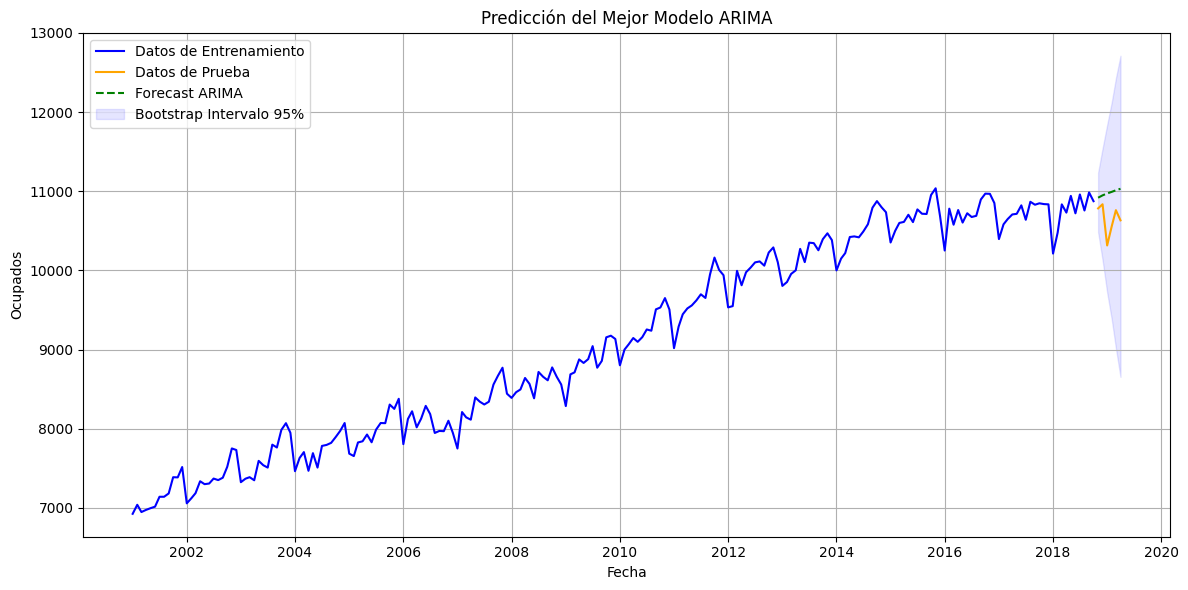

In [21]:
# Crear un rango para el eje x de la predicción
x_for = np.arange(len(data_train), len(data_train) + h)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train["Ocupados"], label="Datos de Entrenamiento", color='blue')
plt.plot(data_test.index, data_test["Ocupados"], label="Datos de Prueba", color='orange')
plt.plot(preds.index, preds['Point_forecast'], label="Forecast ARIMA", color='green', linestyle='--')
plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1, label="Bootstrap Intervalo 95%")
plt.legend(loc='upper left')  # Mover la leyenda a la parte superior izquierda
plt.title('Predicción del Mejor Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Ocupados')
plt.grid(True)
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

aqui voy

Ahora ajusto el modelo ARIMA a todo el conjunto de datos:

In [27]:
# Número de pasos a futuro para la predicción (si es necesario)
h = 6

# Reajustar el modelo ARIMA al conjunto completo de datos
# Usa el modelo con el mejor conjunto de parámetros encontrado
# Por ejemplo, si el mejor modelo es (p,d,q) = (1,1,1)

mejor_modelo = modelos[mejor_criterio]['modelo']
results = mejor_modelo.fit( data["Ocupados"])
results.summary()

mejor_modelo_completo = modelos[mejor_criterio]['modelo']
resultados_completos = mejor_modelo_completo.fit(data["Ocupados"])

# Mostrar el resumen del modelo ajustado
print("Resumen del modelo ajustado a todo el conjunto de datos:")
print(resultados_completos.summary())


Resumen del modelo ajustado a todo el conjunto de datos:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1439.368
Date:                Fri, 23 Aug 2024   AIC                           2886.736
Time:                        15:50:35   BIC                           2900.292
Sample:                    01-01-2001   HQIC                          2892.211
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8034      2.519      3.892      0.000       4.866      14.740
ar.L1          0.4417      0.103      4.285      0.000       0.240       0

C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alfa7\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Resumen del modelo ajustado a todo el conjunto de datos:
                               SARIMAX Results                                
Dep. Variable:               Ocupados   No. Observations:                  220
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1447.774
Date:                Fri, 23 Aug 2024   AIC                           2901.548
Time:                        15:50:46   BIC                           2911.716
Sample:                    01-01-2001   HQIC                          2905.655
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3991      0.138      2.881      0.004       0.128       0.671
ma.L1         -0.7343      0.094     -7.815      0.000      -0.919      -0

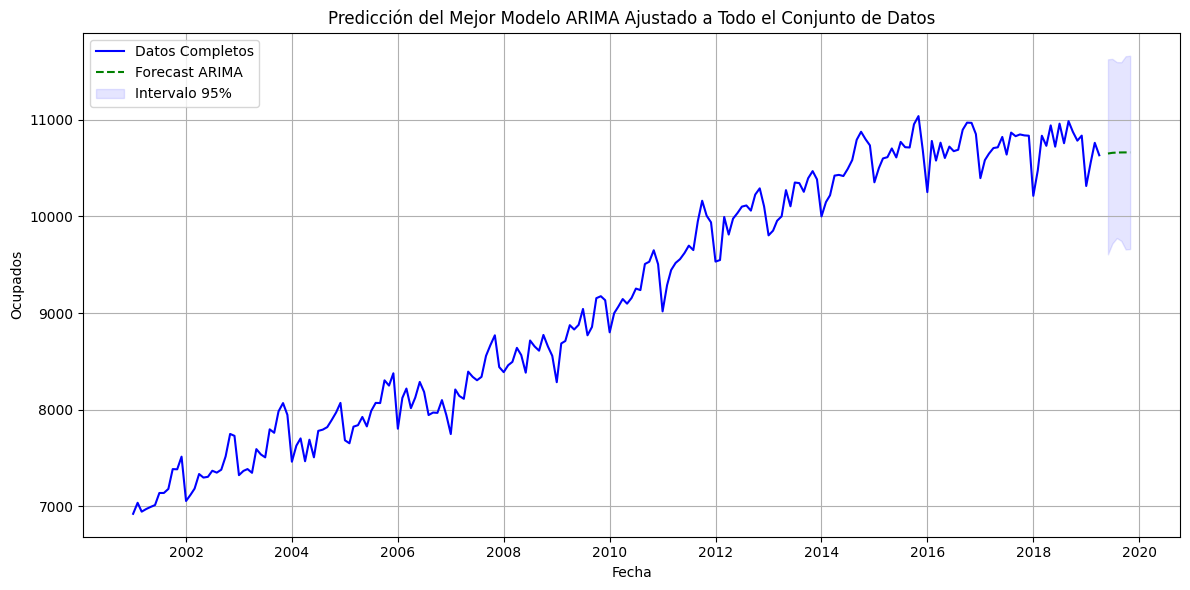

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Número de pasos a futuro para la predicción
h = 6

# Ajustar el modelo ARIMA al conjunto completo de datos usando los parámetros del mejor modelo
# Por ejemplo, si el mejor modelo es (p, d, q) = (1, 1, 1)
p, d, q = (1, 1, 1)  # Reemplaza con los parámetros del mejor modelo encontrado

# Ajustar el modelo ARIMA al conjunto completo de datos
modelo_completo = ARIMA(data["Ocupados"], order=(p, d, q))
resultados_completos = modelo_completo.fit()

# Mostrar el resumen del modelo ajustado
print("Resumen del modelo ajustado a todo el conjunto de datos:")
print(resultados_completos.summary())

# Realizar predicciones para los próximos 6 meses
y_forec = resultados_completos.forecast(steps=h)

# Estimar los intervalos de confianza manualmente
# Primero, obtén la varianza del error
residuals = resultados_completos.resid
error_var = np.var(residuals)

# Calcula el intervalo de confianza para las predicciones
# Usamos un intervalo de confianza del 95%
forecast_errors = np.sqrt(error_var) * np.random.normal(size=(1000, h))  # Simular errores
conf_int_lower = np.percentile(forecast_errors, 2.5, axis=0)  # Percentil 2.5%
conf_int_upper = np.percentile(forecast_errors, 97.5, axis=0)  # Percentil 97.5%

# Crear DataFrame con las predicciones y los intervalos de confianza
preds_completo = pd.DataFrame({
    'Point_forecast': y_forec,
    'lower_95': y_forec + conf_int_lower,
    'upper_95': y_forec + conf_int_upper
})
preds_completo.index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=h, freq='M')  # Ajustar el índice a fechas futuras

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Ocupados"], label="Datos Completos", color='blue')
plt.plot(preds_completo.index, preds_completo['Point_forecast'], label="Forecast ARIMA", color='green', linestyle='--')
plt.fill_between(preds_completo.index, preds_completo['lower_95'], preds_completo['upper_95'], color='blue', alpha=0.1, label="Intervalo 95%")
plt.legend(loc='upper left')  # Mover la leyenda a la parte superior izquierda
plt.title('Predicción del Mejor Modelo ARIMA Ajustado a Todo el Conjunto de Datos')
plt.xlabel('Fecha')
plt.ylabel('Ocupados')
plt.grid(True)
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()


# EVALUANDO SUPUESTOS DEL MODELO CON TODO EL CONJUNTO DE DATOS

1. Normalidad de los Residuos
Para verificar la normalidad de los residuos, puedes usar el test de Jarque-Bera y una gráfica Q-Q.

Jarque-Bera Test: Statistic=251854.18827990867, p-value=0.0


<Figure size 1200x600 with 0 Axes>

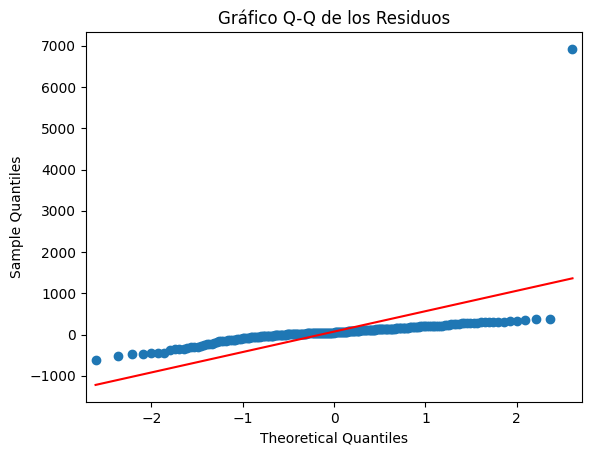

In [29]:
#import statsmodels.api as sm

# Obtener los residuos del modelo
residuos = resultados_completos.resid

# 1. Evaluar Normalidad de los Residuos
# Test de Jarque-Bera
jb_test = sm.stats.jarque_bera(residuos)
print(f"Jarque-Bera Test: Statistic={jb_test[0]}, p-value={jb_test[1]}")

# Gráfico Q-Q
plt.figure(figsize=(12, 6))
sm.qqplot(residuos, line='s')
plt.title('Gráfico Q-Q de los Residuos')
plt.show()

Dado que el p-valor es extremadamente bajo, esto sugiere que los residuos del modelo ARIMA no siguen una distribución normal. Este resultado puede tener implicaciones para la fiabilidad del modelo y sus pronósticos:

Normalidad de los Residuos: La normalidad de los residuos es un supuesto importante en muchos modelos de series temporales. Si los residuos no son normales, el modelo puede no estar capturando todos los aspectos de los datos, lo que podría afectar la precisión de los pronósticos y las inferencias.

Acciones a Tomar:

Revisar el Modelo: Considera si el modelo ARIMA es el adecuado para tus datos. Podrías intentar ajustar diferentes combinaciones de parámetros o explorar otros tipos de modelos.
Transformaciones: A veces, aplicar transformaciones a los datos (como logaritmos) puede ayudar a mejorar la normalidad de los residuos.
Modelos Alternativos: Explora modelos alternativos, como modelos GARCH para datos heterocedásticos, o modelos de suavizado exponencial.

2. Homocedasticidad (Varianza Constante)

Visualiza los residuos ajustados:

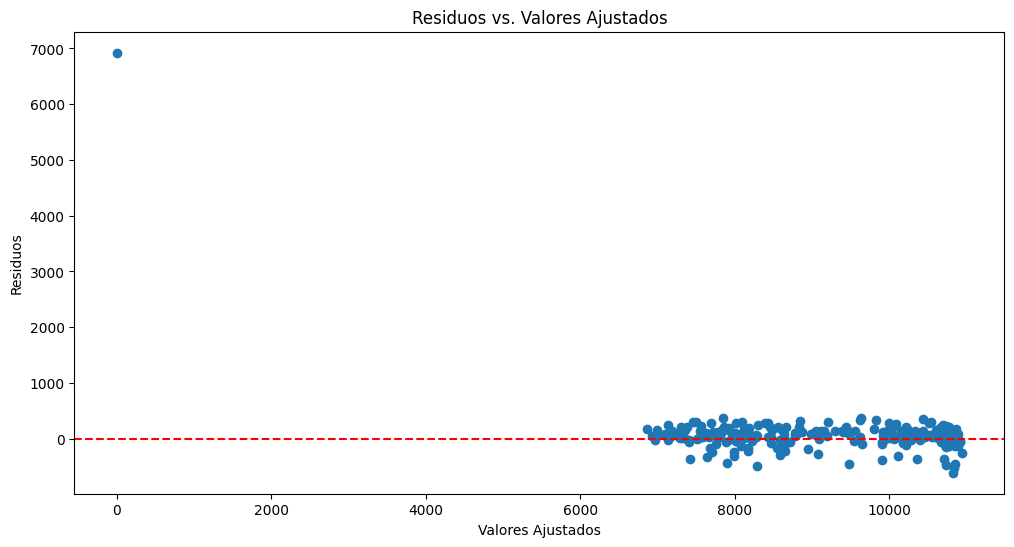

In [30]:
# Graficar residuos ajustados
plt.figure(figsize=(12, 6))
plt.plot(resultados_completos.fittedvalues, residuos, 'o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs. Valores Ajustados')
plt.show()


3. Autocorrelación de los Residuos

Verifica la autocorrelación en los residuos usando ACF y PACF:

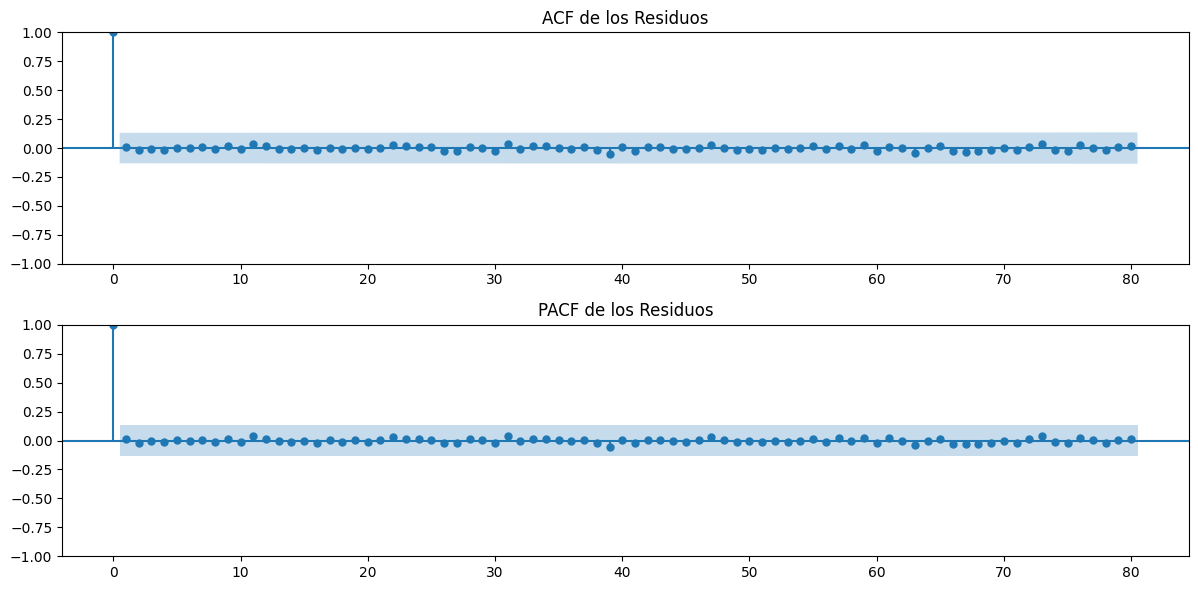

In [31]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(residuos, lags=80, ax=plt.gca())
plt.title('ACF de los Residuos')

plt.subplot(2, 1, 2)
plot_pacf(residuos, lags=80, ax=plt.gca())
plt.title('PACF de los Residuos')

plt.tight_layout()
plt.show()


Conclusiones
Después de ejecutar las pruebas de los supuestos, puedes interpretar los resultados de la siguiente manera:

Normalidad:

Test de Jarque-Bera: Un p-valor bajo indica que los residuos no siguen una distribución normal. Un p-valor alto sugiere normalidad.
Gráfico Q-Q: Si los puntos están alineados con la línea diagonal, los residuos son normales. Desviaciones indican problemas de normalidad.
Homocedasticidad:

Gráfico de Residuos Ajustados: Un patrón aleatorio sin forma de embudo o tendencia indica homocedasticidad. Patrones sugieren heterocedasticidad.
Test de Breusch-Pagan: Un p-valor bajo indica heterocedasticidad. Un p-valor alto indica homocedasticidad.
Autocorrelación:

Gráficos ACF y PACF: Si los residuos muestran autocorrelación significativa, indica que el modelo podría no estar capturando todas las dependencias temporales. Residuos sin autocorrelación sugieren que el modelo es adecuado en términos de capturar dependencias temporales.
Estos análisis te permitirán verificar si el modelo ARIMA es adecuado para tus datos o si necesitas ajustar el modelo o considerar alternativas.

### **7. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. 

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.